In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [12]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder

In [3]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


## Logistic regression

In [4]:
file_paths = glob.glob('eeg_label/*_eeg_label.csv')

data_list = []
labels_list = []
patient_ids = []

for file_path in file_paths:
    eeg_data = pd.read_csv(file_path)
    patient_id = file_path.split('/')[-1]
    
    # Segment the data into non-overlapping 30 second windows
    segment_size = 128 * 30
    num_segments = len(eeg_data) // segment_size
    
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segment = eeg_data['EEG'].iloc[start_idx:end_idx].values
        label = eeg_data['Label'].iloc[start_idx:end_idx].mode()[0]
        
        data_list.append(segment)
        labels_list.append(label)
        patient_ids.append(patient_id)  # Repeat patient ID for each segment

# Convert lists to numpy arrays
X = np.array(data_list)
y = np.array(labels_list)
patient_ids = np.array(patient_ids)

In [5]:
# Reshape to perform minirocket
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

In [6]:
# initialise the minirocket transformer
minirocket = MiniRocket(random_state=123)
X_transformed = minirocket.fit_transform(X_reshaped) # transform the entire dataset using minirocket

# scale the transformed data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_transformed)

In [7]:
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

# Loop over each patient (Leave-One-Patient-Out)
for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y[patient_ids != patient]
    y_test = y[patient_ids == patient]
    
    # train the classifier
    classifier = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)
    classifier.fit(X_train, y_train)
    
    # predict on the test set
    y_pred = classifier.predict(X_test)
    
    # store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)

In [8]:
# evaluate the overall performance
report = classification_report(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
accuracy = accuracy_score(all_labels, all_preds)

print(report)
print(f'Overall Accuracy: {accuracy:.2f}')

              precision    recall  f1-score   support

          AW       0.34      0.21      0.26       155
          LA       0.37      0.25      0.30       229
          MA       0.21      0.16      0.18       327
          DA       0.59      0.69      0.63       777
          RE       0.30      0.42      0.35       186

    accuracy                           0.45      1674
   macro avg       0.36      0.35      0.34      1674
weighted avg       0.43      0.45      0.43      1674

Overall Accuracy: 0.45


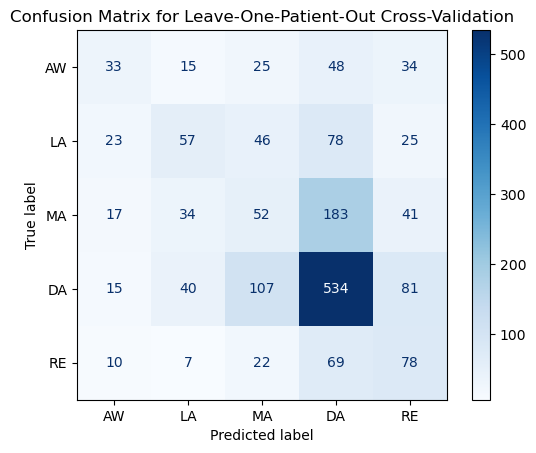

In [9]:
# generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AW', 'LA', 'MA', 'DA', 'RE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Leave-One-Patient-Out Cross-Validation')
plt.show()

### non overlapping 10 second

In [3]:
file_paths = glob.glob('eeg_label/*_eeg_label.csv')

data_list = []
labels_list = []
patient_ids = []

for file_path in file_paths:
    eeg_data = pd.read_csv(file_path)
    patient_id = file_path.split('/')[-1]
    
    # Segment the data into non-overlapping 30 second windows
    segment_size = 128 * 10
    num_segments = len(eeg_data) // segment_size
    
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segment = eeg_data['EEG'].iloc[start_idx:end_idx].values
        label = eeg_data['Label'].iloc[start_idx:end_idx].mode()[0]
        
        data_list.append(segment)
        labels_list.append(label)
        patient_ids.append(patient_id)  # Repeat patient ID for each segment

# Convert lists to numpy arrays
X = np.array(data_list)
y = np.array(labels_list)
patient_ids = np.array(patient_ids)

In [4]:
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

minirocket = MiniRocket(random_state=123)
X_transformed = minirocket.fit_transform(X_reshaped) # transform the entire dataset using minirocket

# scale the transformed data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_transformed)

In [5]:
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

# Loop over each patient (Leave-One-Patient-Out)
for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y[patient_ids != patient]
    y_test = y[patient_ids == patient]
    
    # train the classifier
    classifier = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)
    classifier.fit(X_train, y_train)
    
    # predict on the test set
    y_pred = classifier.predict(X_test)
    
    # store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)

In [13]:
# evaluate the overall performance
report = classification_report(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
f1 = f1_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
precision = precision_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
recall = recall_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(report)
print(f'Overall Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

              precision    recall  f1-score   support

          AW       0.28      0.22      0.25       467
          LA       0.34      0.26      0.29       684
          MA       0.23      0.18      0.20       981
          DA       0.57      0.62      0.60      2328
          RE       0.25      0.35      0.29       574

    accuracy                           0.42      5034
   macro avg       0.33      0.33      0.33      5034
weighted avg       0.41      0.42      0.41      5034

Overall Accuracy: 0.42
F1 Score: 0.41


## XGBoost

In [15]:
# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize variables to store results
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

# Loop over each patient (Leave-One-Patient-Out)
for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y_encoded[patient_ids != patient]
    y_test = y_encoded[patient_ids == patient]
    
    # Initialize the XGBoost classifier without use_label_encoder
    xgb_classifier = xgb.XGBClassifier(eval_metric='mlogloss', random_state=2)
    
    # Train the classifier
    xgb_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = xgb_classifier.predict(X_test)
    
    # Store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)


              precision    recall  f1-score   support

          AW       0.33      0.23      0.27       155
          LA       0.38      0.28      0.32       229
          MA       0.35      0.27      0.30       327
          DA       0.61      0.71      0.65       777
          RE       0.32      0.42      0.36       186

    accuracy                           0.49      1674
   macro avg       0.40      0.38      0.38      1674
weighted avg       0.47      0.49      0.47      1674

Overall Accuracy: 0.49


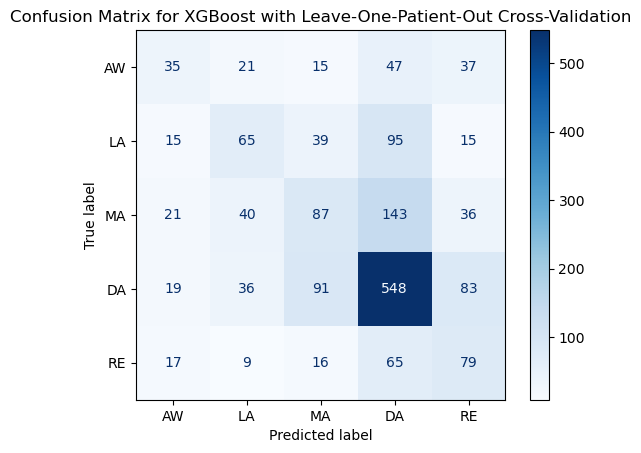

In [16]:
# XGBoost - 30 second

all_preds = label_encoder.inverse_transform(all_preds)
all_labels = label_encoder.inverse_transform(all_labels)

report = classification_report(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
accuracy = accuracy_score(all_labels, all_preds)

print(report)
print(f'Overall Accuracy: {accuracy:.2f}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AW', 'LA', 'MA', 'DA', 'RE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost with Leave-One-Patient-Out Cross-Validation')
plt.show()

In [ ]:
distribution of each anaesthesia class vs prob of xgboost output